In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xasdenoise.xas_data.spectrum import Spectrum 
from xasdenoise.xas_data import data_io, visualization
from xasdenoise.xas_data import preprocess_spectrum
from xasdenoise.xas_data import preprocess_spectrum_list 

# Set global font size for all plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})  # Update the default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Update the default font size for axes titles
plt.rcParams.update({'axes.labelsize': 18})  # Update the default font size for axes labels
plt.rcParams.update({'xtick.labelsize': 18})  # Update the default font size for x tick labels
plt.rcParams.update({'ytick.labelsize': 18})  # Update the default font size for y tick labels

# Load an example dataset

In [2]:
# Load the data
folder_path = './data/raw_spectrum.csv'

data = pd.read_csv(folder_path)
energy = data.iloc[:, 0].values # energy values in eV
mu = data.iloc[:, 1].values # absorption spectrum

# Create the spectrum object
The Spectrum object is expected by many functions within the xasdenoise pipeline. The minimum requirements to create the Spectrum object are the energy of the spectrum and the absorption at every energy. The compulsory arrays for the Spectrum object:
- energy (np.ndarray): 1D array of energy values in eV (same for each spectrum time instance).
- spectrum (np.ndarray): 2D array of spectrum abosprtion values vs. time (spectrum, time). If only a single time instance is provided, the absorption will be converted into a 2D array.

Optional arrays that can be provided to the Spectrum object:
- I0 (np.ndarray, optional): 1D or 2D array of X-ray intensity before the sample.
- I1 (np.ndarray, optional): 1D or 2D array of X-ray intensity after the sample.
- background (np.ndarray, optional): 1D or 2D array of the spectrum background values for every spectrum time instance.
- glitch_mask (np.ndarray, optional): 1D boolean mask for glitches (same for each time instance).
- data_mask (np.ndarray, optional): 1D boolean mask for data (same for each time instance).
- metadata (dict, optional): Dictionary of spectrum metadata.

The metadata dictionary stores the element name, absorption edge energy etc. The absorption edge energy is important for multiple operations within the data processing pipeline. If the metadata is not provided, then the code will try to fill out the values automatically using xraydb Python package. 

The metadata dictionary supports the following entries:
- element (str): name of the element.
- compound (str): name of the chemical compound.
- edge (float): energy value of the absorption edge (in eV).
- edge_type (str): type the absorption edge (K, L).
- all_edges (list, float): all absorption edges if the spectrum contains multiple absorption edges (in eV).
- pre_edge_min_E (float): the minimum energy value of the pre-edge region used for data normalization (in eV).
- pre_edge_max_E (float): the maximum energy value of the pre-edge region used for data normalization (in eV).
- post_edge_min_E (float): the minimum energy value of the post-edge region used for data normalization (in eV).
- post_edge_max_E (float): the maximum energy value of the post-edge region used for data normalization (in eV).

In [3]:
# Create a Spectrum object
# metadata = {'element' : 'Co', 'edge_type' : 'K', 'edge' : 7709, 'compound' : 'Co'}
metadata = {} 

spectrum0 = Spectrum(energy=energy, spectrum=mu[:, np.newaxis], metadata=metadata)

# even if no metadata is provided, the code will try to fill out the values automatically using xraydb
print(f"Edge value {spectrum0.metadata['edge']}")
print(f"Tabulated edge value {spectrum0.metadata['edge_theoretical']}")
print(f"Element {spectrum0.metadata['element']}")
print(f"Absorption edge type {spectrum0.metadata['edge_type']}")
print(f"Number of energy points {spectrum0.spectrum.shape[0]}")
print(f"Number of time instances {spectrum0.spectrum.shape[1]}")     

Calculating the edge position using max derivative...
Edge value 7722.7
Tabulated edge value 7709.0
Element Co
Absorption edge type K
Number of energy points 9999
Number of time instances 1


# Methods of the Spectrum class
If the spectrum is normalized and preprocessed, then the basic initialization of the energy and absorption values is sufficient to proceed to the data denoising steps.

The spectrum object does offer various ways to pre-process the data and some of the methods will be outlined here. These methods include spectrum pre-processing or visualization. 

There is also a group of functions which is able to process a list of Spectrun objects, which will not be discussed here. This functionality is useful if spectra from multiple elements / chemical compounds need to be processed in a similar way. For example, if there are multiple compounds for a given element, then we can interpolate all spectra onto a unified energy grid, visualize all of them together etc.

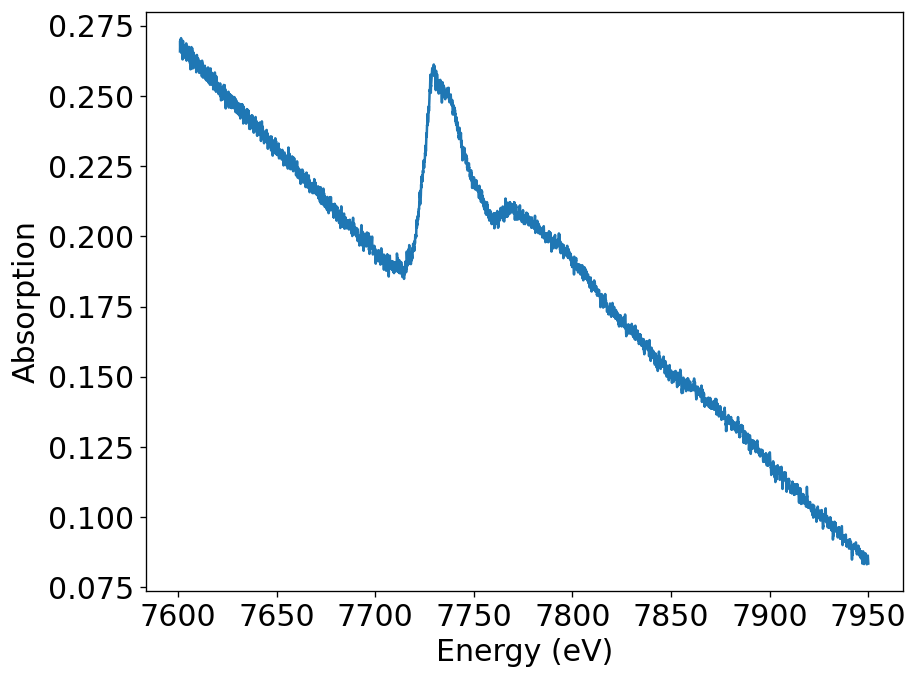

remove_bad_time_instances() requires a time series spectrum with more than 1 time instance. Skipping.


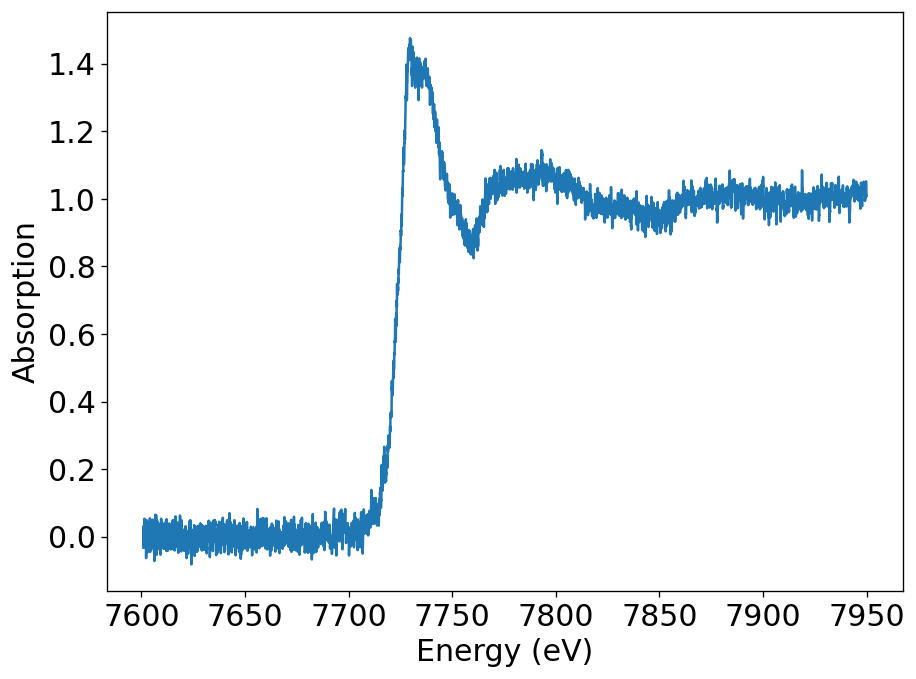

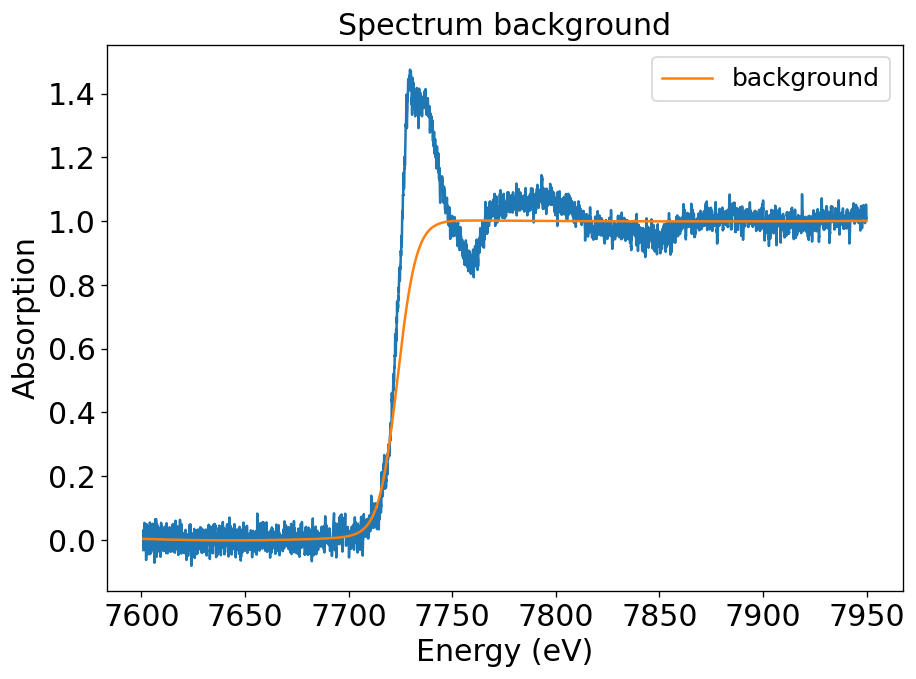

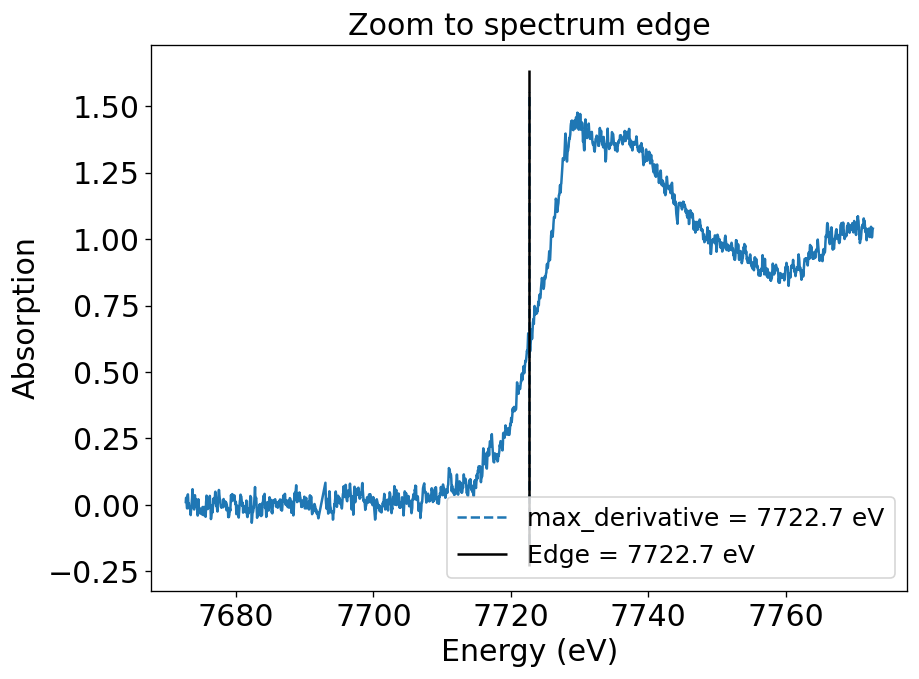

In [4]:
# Visualize
visualization.plot_spectrum(spectrum0)

# Crop to just one absorption edge if there are multiple edges
preprocess_spectrum.crop_other_edges(spectrum0)

# Check and remove corrupted time instances (e.g., loss of signal or something else)
preprocess_spectrum.remove_bad_time_instances(spectrum0)

# Normalize
preprocess_spectrum.normalize_spectrum(spectrum0)
visualization.plot_spectrum(spectrum0)

# Get the spectrum edge step (background)
background = preprocess_spectrum.estimate_background(spectrum0)
visualization.plot_spectrum_background(spectrum0)

# Visualize descriptors of the spectrum
visualization.plot_spectrum_descriptor(spectrum0, descriptor='max_derivative')

# Store the spectrum object
Once finished, we can easily store all of the pre-processed data and various computed arrays/values into an h5 file.

In [5]:
data_io.save_spectra_to_h5(spectrum0, './data/processed_spectrum.h5')
data_io._save_to_csv('./data/processed_spectrum.csv', spectrum0.energy, spectrum0.spectrum)

Saved spectrum Unnamed.
Saved all spectra.
